# Computer Exercise 2 &mdash; Computer Exercise

In this computer exercise we will look at
<ul>
    <li>Representations of 3D rotations</li>
    <li>The orthogonal Procrustes problem (OPP)</li>
    <li>Estimation of rigid transformations</li>
</ul>

### Handing in

As with the previous computer exercise, each student should hand in his/her notebook in Lisam.
Before uploading your `.ipynb` file, make sure that all cells can be executed in sequence.
This can be checked by selecting "Kernel" -> "Restart & Run All" from the menu.

### A note on the TeacherTokens (3 in total in this computer exercise)

At some places (marked clearly in <span style="color: red;">red</span>) in the computer exercise you will be informed that you need a TeacherToken.
A TeacherToken is a short unique key on the form XXXX-XXXX, where each X is either a digit or an uppercase letter.
You obtain TeacherTokens from one of the teachers by discussing your work on the relevant section with the teacher.
TeacherTokens must be added to the `teacher_tokens` set, and are automatically validated by the autograder.
If, for example, you have received the TeacherToken 7A3J-1PHS, you must write `teacher_tokens.add('7A3J-1PHS')` in a code cell.
**If you work in pairs, each of you you needs a set of unique TeacherTokens.**

In [1]:
### Import python modules for linear algebra (numpy) and plotting (matplotlib).

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
np.set_printoptions(precision = 2, suppress = True)


# Create list with teacher tokens.
teacher_tokens = set()

## 1. Axis&ndash;angle representations of 3D rotations

In this section we will verify numerically some properties related to the axis&ndash;angle representation of 3D rotations.
For this, you need to copy your implementation of `rodrigues` from the preparatory exercises (or implement it again) to the next cell.

In [2]:
### Define some utility functions.
teacher_tokens.add('0T0I-944O')
teacher_tokens.add('5YQN-7381')
teacher_tokens.add('Y31L-KVXJ')


import math
def crossm(v):
    """takes a vector v of lenght 3, and returns the cross product matrix of v."""
    assert np.prod(v.shape) == 3
    return np.cross(np.eye(3), np.tile(v.flatten(), (3, 1)))

# Copy your implementation from the preparatory questions.
def rodrigues(nhat, alpha):
    """takes an axis-angle representation (nhat, alpha) and returns a corresponding rotation matrix."""
    assert np.prod(nhat.shape) == 3

    # Make sure that nhat has length one.
    nhat = nhat / np.linalg.norm(nhat)

    # YOUR CODE HERE
    R = np.identity(3) + (1 - math.cos(alpha)) * (crossm(nhat) @ crossm(nhat)) + math.sin(alpha) * crossm(nhat)
    return R


# Verify that your implementation of rodrigues still works.
assert np.linalg.norm(rodrigues(np.array([1, 0, 0]), np.pi / 4) \
    - np.array([[1, 0, 0], [0, np.sqrt(2) / 2, -np.sqrt(2) / 2], [0, np.sqrt(2) / 2, np.sqrt(2) / 2]])) < 1e-10

### 1.1 Recovering axis&ndash;angle representations

We observe that if $\mathbf{A} \in \mathbb{R}^{n \times n}$, then $\det(\lambda\mathbf{A}) = \lambda^n \mathbf{A}^n$.
This means that if $\mathbf{Q} \in \mathbb{R}^{3 \times 3}$ is orthogonal, then either $\mathbf{Q}$ or $-\mathbf{Q}$ is a rotation matrix.

Now recall that the QR decomposition of a matrix factorises it as the product of an orthogonal matrix $\mathbf{Q}$ and an upper triangular matrix.
If we generate a random matrix in $\mathbb{R}^{3 \times 3}$ and use the $\mathbf{Q}$ from its QR decomposition, then either $\mathbf{Q}$ or $-\mathbf{Q}$ is a rotation matrix (with an unknown axis&ndash;angle pair).

### Task: recover the axis&ndash;angle representation from a random rotation matrix

<ul>
    <li>
        At this stage we will not worry about singular or exceptional cases, as they are <i>extremely</i> unlikely for matrices generated in the way we did.
        Note, however, that they occur more frequently in practice for non-random rotations!
    </li>
    <li>You can use the normal case from Algorithm 11.1 from IREG, or you can use page 1 from lecture 1H.</li>
    <li>The functions <code>np.trace</code> and <a href="https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html"><code>np.arctan2</code></a> might be useful here.</li>
</ul>

In [3]:
# Generate a random rotation Q according to the recipe above.
# We only need the Q, which is the first of the returned
# values (hence the [0] at the end).
Q = np.linalg.qr(np.random.randn(3, 3))[0]
Q = Q if np.linalg.det(Q) > 0 else -Q

def invcrossm(M):
    assert M.shape == (3,3)
    M = 1/2*(np.array([M[2,1]-M[1,2],
                        M[0,2]-M[2,0],
                          M[1,0]-M[0,1]]))
    return M

# Recover axis and angle from a rotation matrix.
# Beware: does not handle singular or exceptional cases!
def recover_axis_angle(Q):
    c = (np.trace(Q)-1)/2
    v = invcrossm(Q)
    s = np.linalg.norm(v)
    nhat = v/s
    alpha = np.arctan2(s,c)
    return (nhat, alpha)

(nhat, alpha) = recover_axis_angle(Q)
print(alpha)

1.9785570174774445


In [4]:
# Verify that rodrigues can recreate Q from nhat and alpha.
assert np.linalg.norm(rodrigues(nhat, alpha) - Q) < 1e-10

### 1.2 Matrix exponentials and rotations

In the lectures we introduced the *matrix exponential* of a matrix $\mathbf{A}$ and defined it as a power series,

$$
e^{\mathbf{A}} = \sum_{k = 0}^\infty \frac{\mathbf{A}}{k!}.
$$

We also saw that this can be used to create rotation matrices from axis&ndash;angle representations $(\hat{\mathbf{n}},\alpha)$, by simply computing $e^{\alpha[\hat{\mathbf{n}}]_\times}$.
In NumPy<sup>1</sup> there is currently no convenient function that computes the matrix exponential, so we will take an alternative approach to computing it.

Let $\mathbf{N}$ be defined as in equation (11.26) in IREG, page 171.
As we see in that passage of IREG, $\mathbf{N}$ and $e^{\mathbf{N}}$ have the same eigenvectors, and the corresponding eigenvalies are related in a very simple way.


### Task: use the eigendecompositon to compute the matrix exponential $e^{\alpha[\hat{\mathbf{n}}]_\times}$

<ul>
    <li>Since some of the eigenvectors are complex, we must use the <i>conjugate transpose</i> $\mathbf{E}^*$, which can be written in code as <code>E.conjugate().T</code>.</li>
    <li>You can use <code>np.diag</code> to create a diagonal matrix from a vector.</li>
    <li>
        Due to numerics, the resulting <code>expN</code> might have a <i>very</i> small imaginary part unless removed.
        Remove this using <code>expN = expN.real</code> (or similar).
    </li>
    <li><b>Note:</b> <span style="color: red;">You need a TeacherToken for the answer here!</span></li>
</ul>

<br>
<br>
<br>
<sup>1</sup> SciPy has such a function, <code>scipy.linalg.expm</code>, but we will not use it here.

In [5]:
# The variables Q, nhat, and alpha should already be defined from earlier cells.

#D = np.diag([1, np.exp(1j*alpha),np.exp(-1j*alpha)])

#t = [1,1,1] #vector supposedly not collinear with nhat to create ON basis
#phat = np.cross(t,nhat)/np.linalg.norm(np.cross(t,nhat))
#qhat = np.cross(nhat, phat)

#E = np.array([nhat, (phat-1j*qhat)/2**0.5, (phat+1j*qhat)/2**0.5]).T

(D, E) = np.linalg.eig(alpha * crossm(nhat))
Econj = E.conjugate().T
xD= np.diag(np.exp(D))
print('nhat\n',nhat)
print('E\n',E)
print('E*\n',Econj)
print('D\n',D)

expN =  E @ xD@ Econj
expN = expN.real
print('expN\n' , expN)
print('Q\n', Q)

assert np.linalg.norm(expN - Q) < 1e-10

nhat
 [ 0.46 -0.54 -0.71]
E
 [[ 0.63+0.j    0.63-0.j   -0.46+0.j  ]
 [ 0.2 +0.56j  0.2 -0.56j  0.54+0.j  ]
 [ 0.26-0.43j  0.26+0.43j  0.71+0.j  ]]
E*
 [[ 0.63-0.j    0.2 -0.56j  0.26+0.43j]
 [ 0.63+0.j    0.2 +0.56j  0.26-0.43j]
 [-0.46-0.j    0.54-0.j    0.71-0.j  ]]
D
 [-0.+1.98j -0.-1.98j  0.+0.j  ]
expN
 [[-0.1   0.31 -0.95]
 [-0.99  0.01  0.11]
 [ 0.04  0.95  0.3 ]]
Q
 [[-0.1   0.31 -0.95]
 [-0.99  0.01  0.11]
 [ 0.04  0.95  0.3 ]]


## 2. Estimation of rigid transformations

In this section we will study the estimation of rigid transformations.
Before we consider general rigid transformations, however, we will first estimate transformations consisting of only rotations.
As you may recall from the lectures, this is called the *Orthogonal Procrustes Problem* (OPP).

### 2.1 Generating data

We will start by creating *synthetic data* (in contrast to *real* or *measurement* data), which means that we will have access to the *ground truth* transformation.
This is a common first step when trying an estimation method, because it makes it possible to compare the estimate to the actual desired object.

### Task: generate random $\mathbf{a}_k,\mathbf{b}_k \in \mathbb{R}^3$ such that $\mathbf{b}_k = \mathbf{R}\mathbf{a}_k$ for each $k = 1,\ldots,n$, where $\mathbf{R}$ is a rotation

<ul>
    <li>We will use a small, convenient, value for $n$, e.g. $n=10$.</li>
    <li>As usual, let $\mathbf{A} = \begin{pmatrix} \mathbf{a}_1 & \ldots & \mathbf{a}_n \end{pmatrix}$ and $\mathbf{B} = \begin{pmatrix} \mathbf{b}_1 & \ldots & \mathbf{b}_n \end{pmatrix}$.</li>
    <li>Use e.g. your function <code>rodrigues</code> to generate the rotation.</li>
    <li>The function <code>np.random.randn</code> is useful in this task.</li>
    <li><b>Note:</b> <span style="color: red;">You need a TeacherToken for the answer here!</span></li>
</ul>

<IPython.core.display.Javascript object>


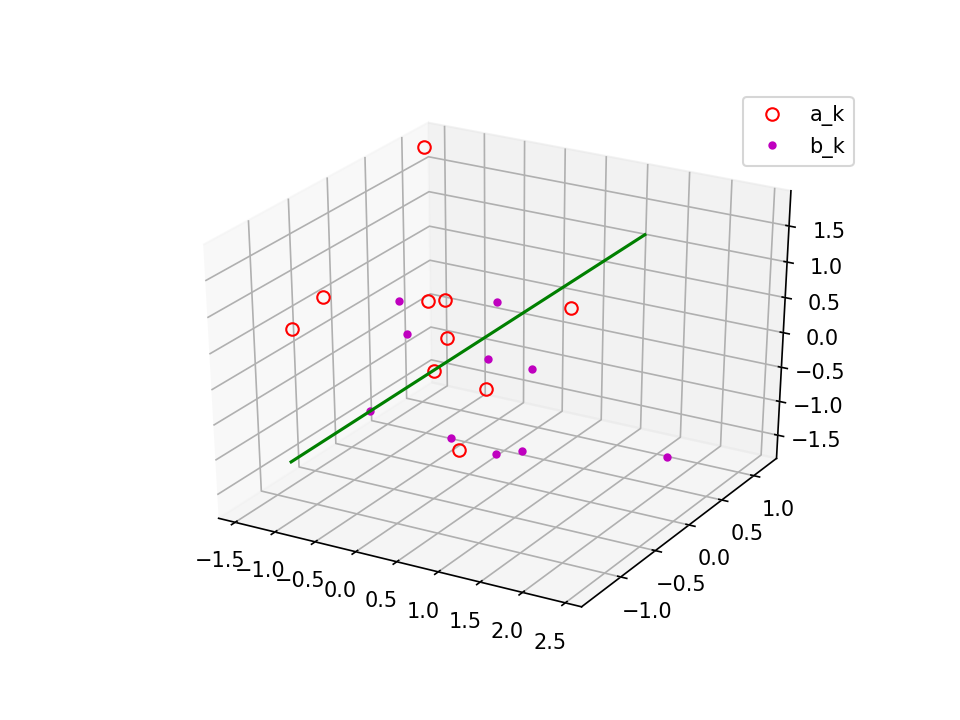

In [6]:
# Generate and plot the synthetic data.

n = 10
Rgt = rodrigues(np.array([1/3,1/3,1/3]), 1*math.pi)
A = np.random.randn(3, n)
B = Rgt @ A

assert np.linalg.norm(Rgt.T @ Rgt - np.eye(3)) < 1e-10
assert A.shape == (3, n) and B.shape == (3, n)


# Find rotation axis from Rgt.
(D, E) = np.linalg.eig(Rgt)
L = 2 * np.tile(E[:, np.abs(D - 1) < 1e-7].real, (1, 2))
L[:, 0] = -L[:, 0]

# Plot original and rotated points, as well as the rotation axis.
# Verify that this looks like a rotation.
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(A[0, :], A[1, :], A[2, :], 'ro', mfc = 'None', mec = 'r')
ax.plot3D(B[0, :], B[1, :], B[2, :], 'm.')
ax.plot3D(L[0, :], L[1, :], L[2, :], 'g')
ax.legend(['a_k', 'b_k'])
plt.show()

### 2.2 Estimation of 3D rotations (OPP)

Now that we have some synthetic data in $\mathbf{A}$ and $\mathbf{B}$, we can use OPP to estimate a rotation from these.

### Task: implement a function `opp_rotation` that uses OPP to estimate a rotation

<ul>
    <li>Use Algorithm 15.1 on page 261 in IREG.</li>
    <li>
        <i>Never test equality for floating point numbers</i> &mdash; instead, test that the difference is small.
        Thus, instead of <code>if x == 5.13:</code>, write <code>if abs(x - 5.13) &lt; 1e-3</code> (adjusting the tolerance as necessary).
        However, in Algorithm 15.1, it is sufficient to test that the determinant is positive.
    </li>
</ul>

In [7]:
# Implementation of opp_rotation.

def opp_rotation(A, B):
    """determines a rotation matrix R such that B = R @ A + E, where the noise E is as small as possible"""
    assert A.shape == (3, n) and B.shape == (3, n)
    U, S, V = np.linalg.svd(A@B.T)
    R = V.T @ U.T
    if abs(np.linalg.det(R)-1) < 1e-3:
        return R
    else:
        print('no solution')

In [8]:
# Estimate Rest from A and B. Since the data is noise free, this should be identical to Rgt.
Rest = opp_rotation(A, B)
assert np.linalg.norm(Rgt - Rest) < 1e-10

### 2.3 OPP on noisy data

Now that we are confident that `opp_rotation` works, we will test it on noisy data.
We will use the synthetic data from before, but add a small random perturbation to it.
The noisy point sets will be called `An` and `Bn`, respectively.
We can rotate `An` and compare to `Bn`, for instance in a plot.

<IPython.core.display.Javascript object>


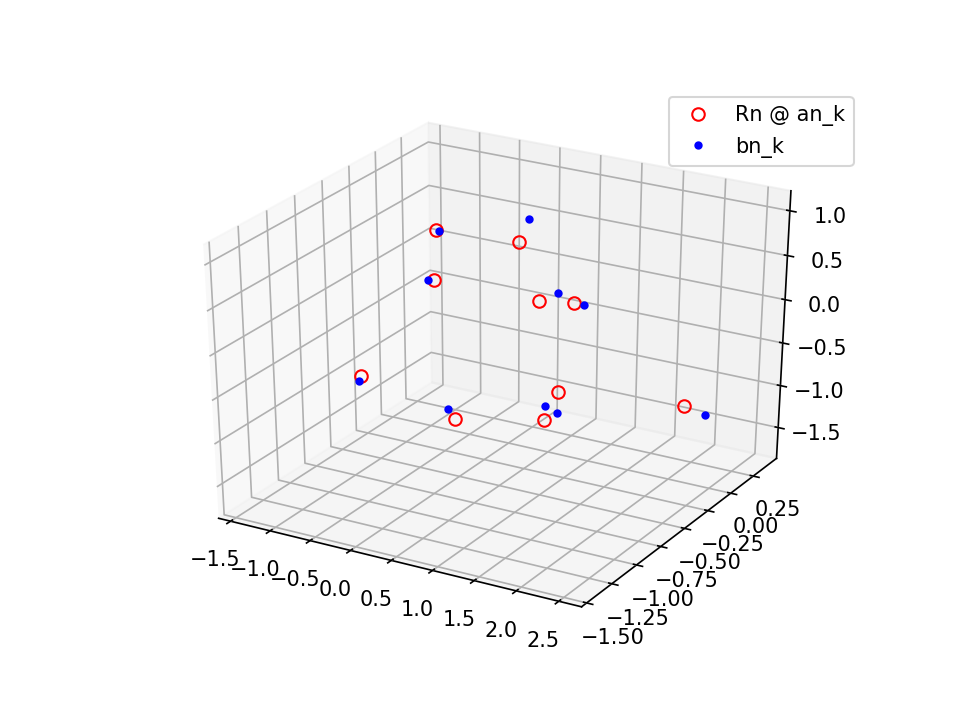

In [9]:
# Add noise to the data.
sigma = 0.1
An = A + sigma * np.random.randn(*A.shape)
Bn = B + sigma * np.random.randn(*B.shape)


# Estimate Rn from An and Bn.
Rn = opp_rotation(An, Bn)


# Plot Bn and Cn = Rn @ An. These should generally be close.
Cn = Rn @ An
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(Cn[0, :], Cn[1, :], Cn[2, :], 'ro', mfc = 'None', mec = 'r')
ax.plot3D(Bn[0, :], Bn[1, :], Bn[2, :], 'b.')
ax.legend(['Rn @ an_k', 'bn_k'])
plt.show()

### 2.4 Estimating rigid transformations

We are now ready to estimate full rigid transformations, i.e. including both rotations and translations.
For this reason, we again start by generating some synthetic data.
The only difference from before is that this time we include a random translation as well.

### Task: generate random $\mathbf{a}_k,\mathbf{b}_k \in \mathbb{R}^3$ such that $\mathbf{b}_k = \mathbf{R}\mathbf{a}_k + \mathbf{t}$ for each $k = 1,\ldots,n$, where $\mathbf{R}$ is a rotation and $\mathbf{t}$ is a translation

<ul>
    <li>
        Since <code>np.random.randn</code> has expectation zero, it will be more interesting to use <code>np.random.rand</code>, e.g. as <code>tgt = 5 * np.random.rand(3, 1)</code>.
        This way, the translations will usually be noticeable.
    </li>
    <li>You may find <code>np.tile</code> useful here.</li>
</ul>

[ 1.8  -0.33 -0.37]


<IPython.core.display.Javascript object>


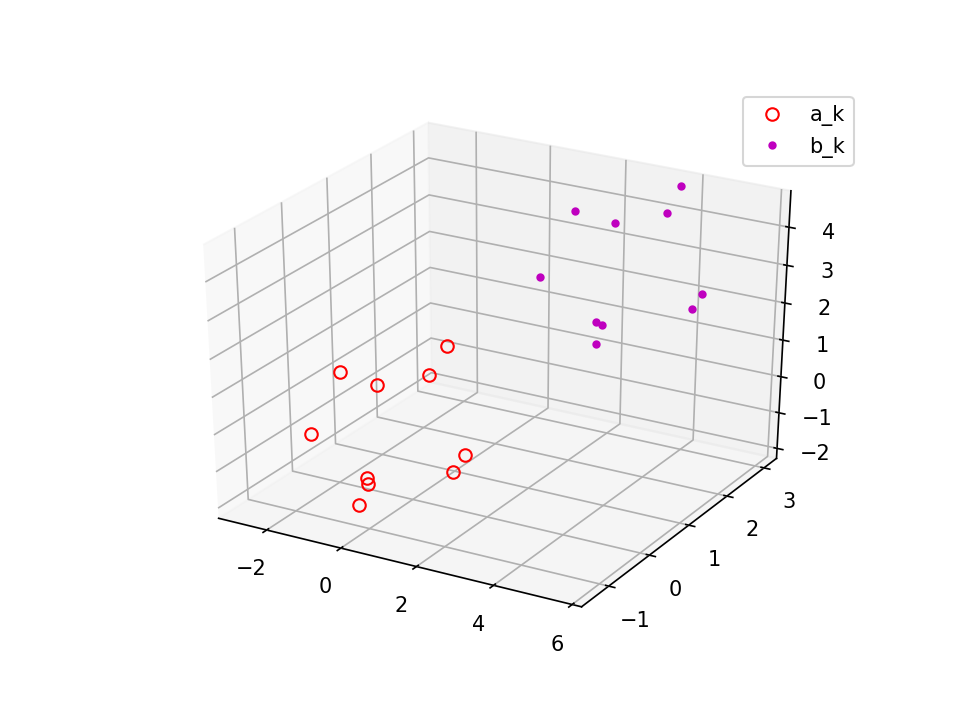

In [10]:
# Generate and plot the synthetic data.

n = 10
Rgt = rodrigues(np.array([1/3,1/3,1/3]), 2*math.pi)
tgt = 5 * np.random.rand(3,1)
A = np.random.randn(3, n)
B = Rgt @ A + tgt 
print(A[:,1])
assert np.linalg.norm(Rgt.T @ Rgt - np.eye(3)) < 1e-10
assert A.shape == (3, n) and B.shape == (3, n)


# Find rotation axis from Rgt.
(D, E) = np.linalg.eig(Rgt)
L = 2 * np.tile(E[:, np.abs(D - 1) < 1e-7].real, (1, 2))
L[:, 0] = -L[:, 0]

# Plot original and transformed points.
# Verify that this looks like a rigid transformation.
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(A[0, :], A[1, :], A[2, :], 'ro', mfc = 'None', mec = 'r')
ax.plot3D(B[0, :], B[1, :], B[2, :], 'm.')
ax.legend(['a_k', 'b_k'])
plt.show()

### Task: implement `estimate_rigid`

<ul>
    <li>This is outlined in Algorithm 15.4 on page 263 in IREG.</li>
    <li>On step 4 in Algorithm 15.4, you can call your existing function <code>opp_rotation</code>.</li>
    <li>You may find <code>np.mean</code> and <code>np.tile</code> useful here, but you may have to fight NumPy to keep the dimensions!</li>
    <li><b>Note:</b> <span style="color: red;">You need a TeacherToken for the answer here!</span></li>
</ul>

In [11]:
# Implementation of estimate_rigid.
def estimate_rigid(A, B):
    """determines a rotation matrix R and a translation vector such that
        each b_k = R @ a_k + e_k, where the noise e_k is as small as possible"""
    assert A.shape == (3, n) and B.shape == (3, n)

    # compute centroids
    a0 = np.array([0,0,0])
    b0 = a0
    
    for i in range(A.shape[1]):
        a0 = a0 + A[:,i]
        b0 = b0 + B[:,i]
    
    a0 = a0 / A.shape[1]
    b0 = b0 / B.shape[1]
    
    #compute barycentric coordinates
    aprim = A - np.tile(np.vstack(a0), A.shape[1])
    bprim = B - np.tile(np.vstack(b0), B.shape[1])
    
    R = opp_rotation(aprim, bprim)
    t = np.vstack(b0 - R @ a0)
    return (R, t)

In [12]:
# Estimate Rest and test from A and B. Since the data is noise free, these should be identical to Rgt and tgt.
(Rest, test) = estimate_rigid(A, B)
assert np.linalg.norm(Rgt - Rest) < 1e-10
assert np.linalg.norm(tgt - test) < 1e-10

### 2.5 Rigid transformations from noisy data

Finally, we can add noise to the data and see how the estimation performs.

<IPython.core.display.Javascript object>


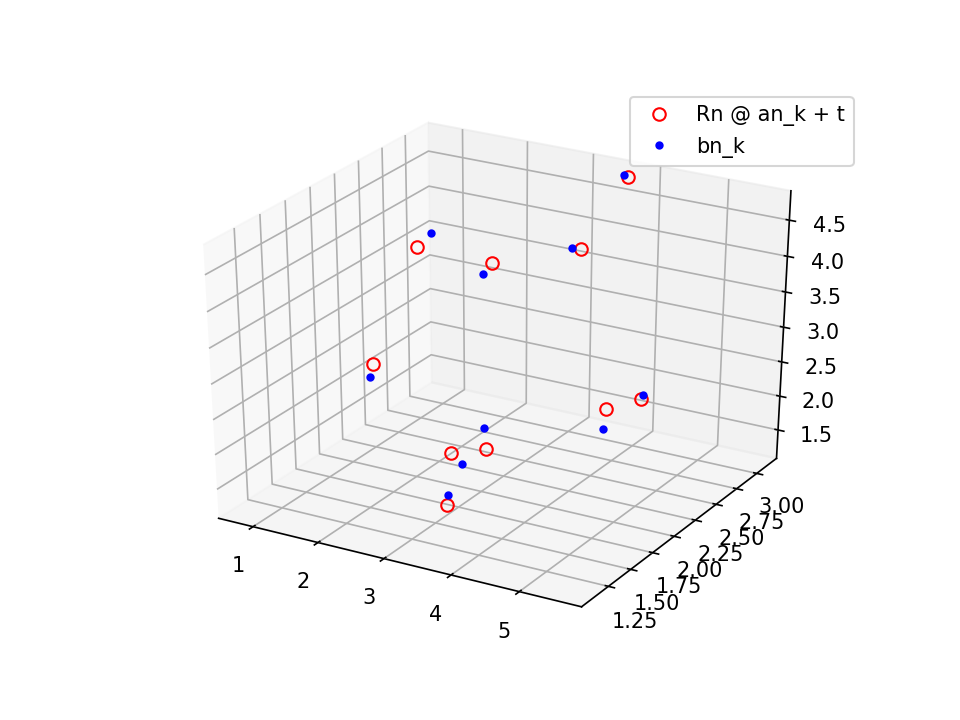

In [13]:
# Add noise to the data.
sigma = 0.1
An = A + sigma * np.random.randn(*A.shape)
Bn = B + sigma * np.random.randn(*B.shape)


# Estimate Rn and tn from An and Bn.
(Rn, tn) = estimate_rigid(An, Bn)
T = np.tile(tn, (1, n))


# Plot Bn and Cn = Rn @ An + T. These should generally be close.
Cn = Rn @ An + T
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(Cn[0, :], Cn[1, :], Cn[2, :], 'ro', mfc = 'None', mec = 'r')
ax.plot3D(Bn[0, :], Bn[1, :], Bn[2, :], 'b.')
ax.legend(['Rn @ an_k + t', 'bn_k'])
plt.show()

In [14]:
# This cell checks your teacher_tokens when submitted. Please ignore.